In [139]:
from neurodesign import geneticalgorithm, generate, msequence 
import sys
from scipy.stats.stats import pearsonr
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import normal as nm
from IPython.display import Image

import scipy

%matplotlib inline

### Original settings of optimisation

In [42]:
EXP = geneticalgorithm.experiment( 
    TR = 0.68, 
    P = [0.5, 0.5], 
    C = [[0.5, -0.5]], 
    rho = 0.3, 
    n_stimuli = 2, 
    n_trials = 96, 
    duration = 212, 
    resolution = 0.136, 
    stim_duration = 1.5, 
    t_pre = 0.0, 
    t_post = 0.5, 
    maxrep = 6, 
    hardprob = False, 
    confoundorder = 3, 
    ITImodel = 'exponential', 
    ITImin = 0.0, 
    ITImean = 0.2, 
    ITImax = 6.0, 
    restnum = 0, 
    restdur = 0.0) 


POP = geneticalgorithm.population( 
    experiment = EXP, 
    G = 20, 
    R = [0.4, 0.4, 0.2], 
    q = 0.01, 
    weights = [0.0, 0.1, 0.4, 0.5], 
    I = 4, 
    preruncycles = 1000, 
    cycles = 4000, 
    convergence = 1000, 
    outdes = 4, 
    folder = '/Users/Joke/Downloads') 


Randomly drawing +/- 1000 designs:

In [71]:
POP.add_new_designs(R=[330,330,330])


For all those random designs: compute optimality score and correlation between regressors.

In [72]:
correlations = []
scores = []

for i in range(len(POP.designs)):
    POP.designs[i].designmatrix()
    cor = np.corrcoef(POP.designs[i].Xconv[:,0],POP.designs[i].Xconv[:,1])[1,0]
    POP.designs[i].FCalc(weights=[0,0.1,0.4,0.5],Aoptimality=True)
    correlations.append(cor)
    score = POP.designs[i].F
    scores.append(score)


Almost all correlations are around -0.8.

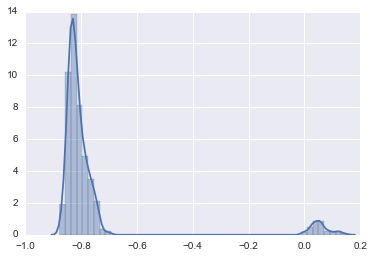

In [73]:
sns.distplot(correlations)

The few designs that result in very low (absolute) correlations, are wrong designs: (here for example: fixed trial sequence and twice as many trials in one condition as in another.

the order of the trials is: [0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1]


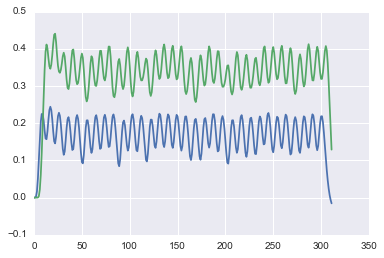

In [70]:
# where are those designs with very low correlations?

idx=(np.where(np.array(correlations)==np.min([abs(x) for x in correlations])))[0][0]
print("the order of the trials is: %s"%(str(POP.designs[idx].order)))
plt.plot(POP.designs[idx].Xconv)

However, there seems to be a negative correlation between the correlation and the score => optimiser will enforce negative correlations.

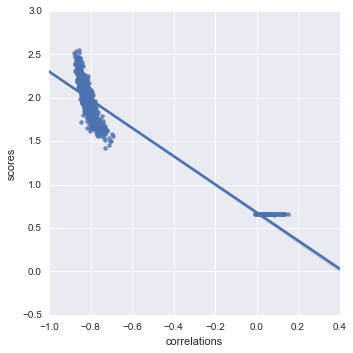

In [74]:
df = pd.DataFrame({"scores":scores,"correlations":correlations})
sns.lmplot('correlations','scores',data=df)

### Let's take other settings, optimising for contrasts of regressors vs baseline.

In [75]:
EXP = geneticalgorithm.experiment( 
    TR = 0.68, 
    P = [0.5, 0.5], 
    C = [[0,1],[1,0]], 
    rho = 0.3, 
    n_stimuli = 2, 
    n_trials = 96, 
    duration = 212, 
    resolution = 0.136, 
    stim_duration = 1.5, 
    t_pre = 0.0, 
    t_post = 0.5, 
    maxrep = 6, 
    hardprob = False, 
    confoundorder = 3, 
    ITImodel = 'exponential', 
    ITImin = 0.0, 
    ITImean = 0.2, 
    ITImax = 6.0, 
    restnum = 0, 
    restdur = 0.0) 


POP = geneticalgorithm.population( 
    experiment = EXP, 
    G = 20, 
    R = [0.4, 0.4, 0.2], 
    q = 0.01, 
    weights = [0.0, 0.1, 0.4, 0.5], 
    I = 4, 
    preruncycles = 1000, 
    cycles = 4000, 
    convergence = 1000, 
    outdes = 4, 
    folder = '/Users/Joke/Downloads') 


In [76]:
POP.add_new_designs(R=[330,330,330])


In [77]:
correlations = []
scores = []

for i in range(len(POP.designs)):
    POP.designs[i].designmatrix()
    cor = np.corrcoef(POP.designs[i].Xconv[:,0],POP.designs[i].Xconv[:,1])[1,0]
    POP.designs[i].FCalc(weights=[0,0.1,0.4,0.5],Aoptimality=True)
    correlations.append(cor)
    score = POP.designs[i].F
    scores.append(score)


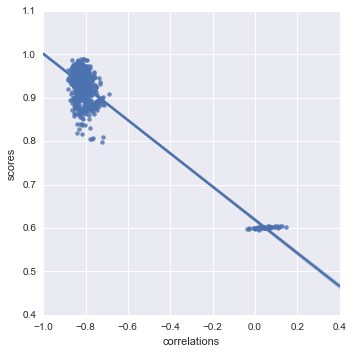

In [78]:
df = pd.DataFrame({"scores":scores,"correlations":correlations})
sns.lmplot('correlations','scores',data=df)

## So with contrast [1,-1] the power increases with negative correlation? A simulation.

Based on those 1000 random designs, let's simulate what the T stats would look like if the effect size for condition 1 = 0.2 and for condition 2 = 0.35.

In [132]:
mnT = []

for idx,des in enumerate(POP.designs):
    tvalues = []

    for sim in range(100):
        Y = des.Xconv[:,0]*0.2 + des.Xconv[:,1]*0.35 + nm(0,1,des.Xconv.shape[0])
        dataset = pd.DataFrame({"y":Y,"x1":des.Xconv[:,1],"x2":des.Xconv[:,0]})

        Ymat = np.matrix(Y)
        Xmat = np.matrix([des.Xconv[:,1],des.Xconv[:,0]])

        beta = np.matrix([1,-1])*scipy.linalg.inv(Xmat*Xmat.T)*Xmat*Ymat.T
        Varbeta = np.var(Ymat)*np.matrix([1,-1])*scipy.linalg.inv(Xmat*Xmat.T)*np.matrix([1,-1]).T
        T = float(beta/Varbeta)
        tvalues.append(T)

    mnT.append(np.mean(tvalues))


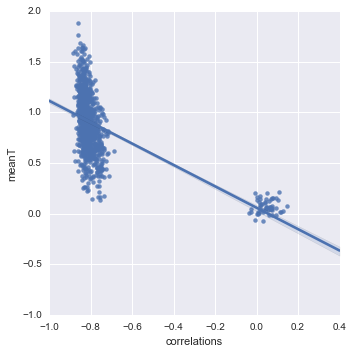

In [137]:
df = pd.DataFrame({"scores":scores,"correlations":correlations,'meanT':mnT})
sns.lmplot('correlations','meanT',data=df)

## But why?

It's in the formulae below.
1) Both numerator and denominator have (X'X) which is why Russ could find also higher beta values.
2) The variance is under control due to the specification of the c in computation.  Basically: higher anticorrelation between the regressors increases 

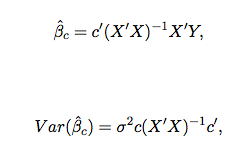

In [140]:
Image('bvarb.png')